## Preambule

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

C:\Users\dekkerm\AppData\Local\Temp\2\ipykernel_2984\3550119306.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Read data

In [2]:
xr_dataread = xr.open_dataset("K:/ECEMF/T5.2/xr_dataread_pbl.nc")
xr_nld_raw = xr.open_dataset("K:/ECEMF/T5.2/Allocations/xr_alloc_NLD_pbl.nc")

In [3]:
basic_settings = {
    "Temperature": 1.5,
    "Risk": 0.5,
    "NegEmis": 0.5,
    "NonCO2red": 0.5,
    "Scenario": "SSP2",
    "Convergence_year": 2050,
    "Discount_factor": 2.0,
    "Historical_startyear": 1950,
}
rules = ["GF", "PCC", "PC", "AP", "ECPC", "GDR"]
# rulecolors = np.array([(121, 125, 28), 'forestgreen', 'goldenrod', 'mediumvioletred', 'tomato', 'steelblue'])/256
rulecolors = (
    np.array(
        [
            (90, 51, 36),
            (141, 145, 31),
            (0, 156, 223),
            (157, 0, 100),
            (230, 173, 31),
            (61, 29, 92),
        ]
    )
    / 256
)
rulenames = [
    "Grandfathering (GF)",
    "Per capita convergence (PCC)",
    "Immediate per capita (IPC)",
    "Ability to pay (AP)",
    "Equal cumulative per capita (ECPC)",
    "Greenhouse Development Rights (GDR)",
]

In [11]:
emis_1990 = xr_dataread.GHG_hist.sel(Region="NLD", Time=1990)

In [5]:
def vert(ax, valx, valy, ruleno):
    ax.plot([valx, valx], [-1e3, valy], "--", c=rulecolors[ruleno], lw=2, zorder=1e99)
    ax.plot([valx, valx], [-1e3, valy], "o", c=rulecolors[ruleno], ms=10, zorder=1e99)

## Plot

In [6]:
dt = 0.5
xr_nld = xr_nld_raw  # .sel(Risk=0.5, NegEmis=0.5, NonCO2red=0.5)#.reindex(Temperature=np.arange(1.5, 2.405, 0.01).round(2))
# xr_nld = xr_nld.interpolate_na(dim='Temperature')

In [7]:
def textit(strin):
    split = strin.split(" ")
    strin2 = ""
    for s in split:
        strin2 = strin2 + r"$\it{" + s + r"}$ "
    return strin2

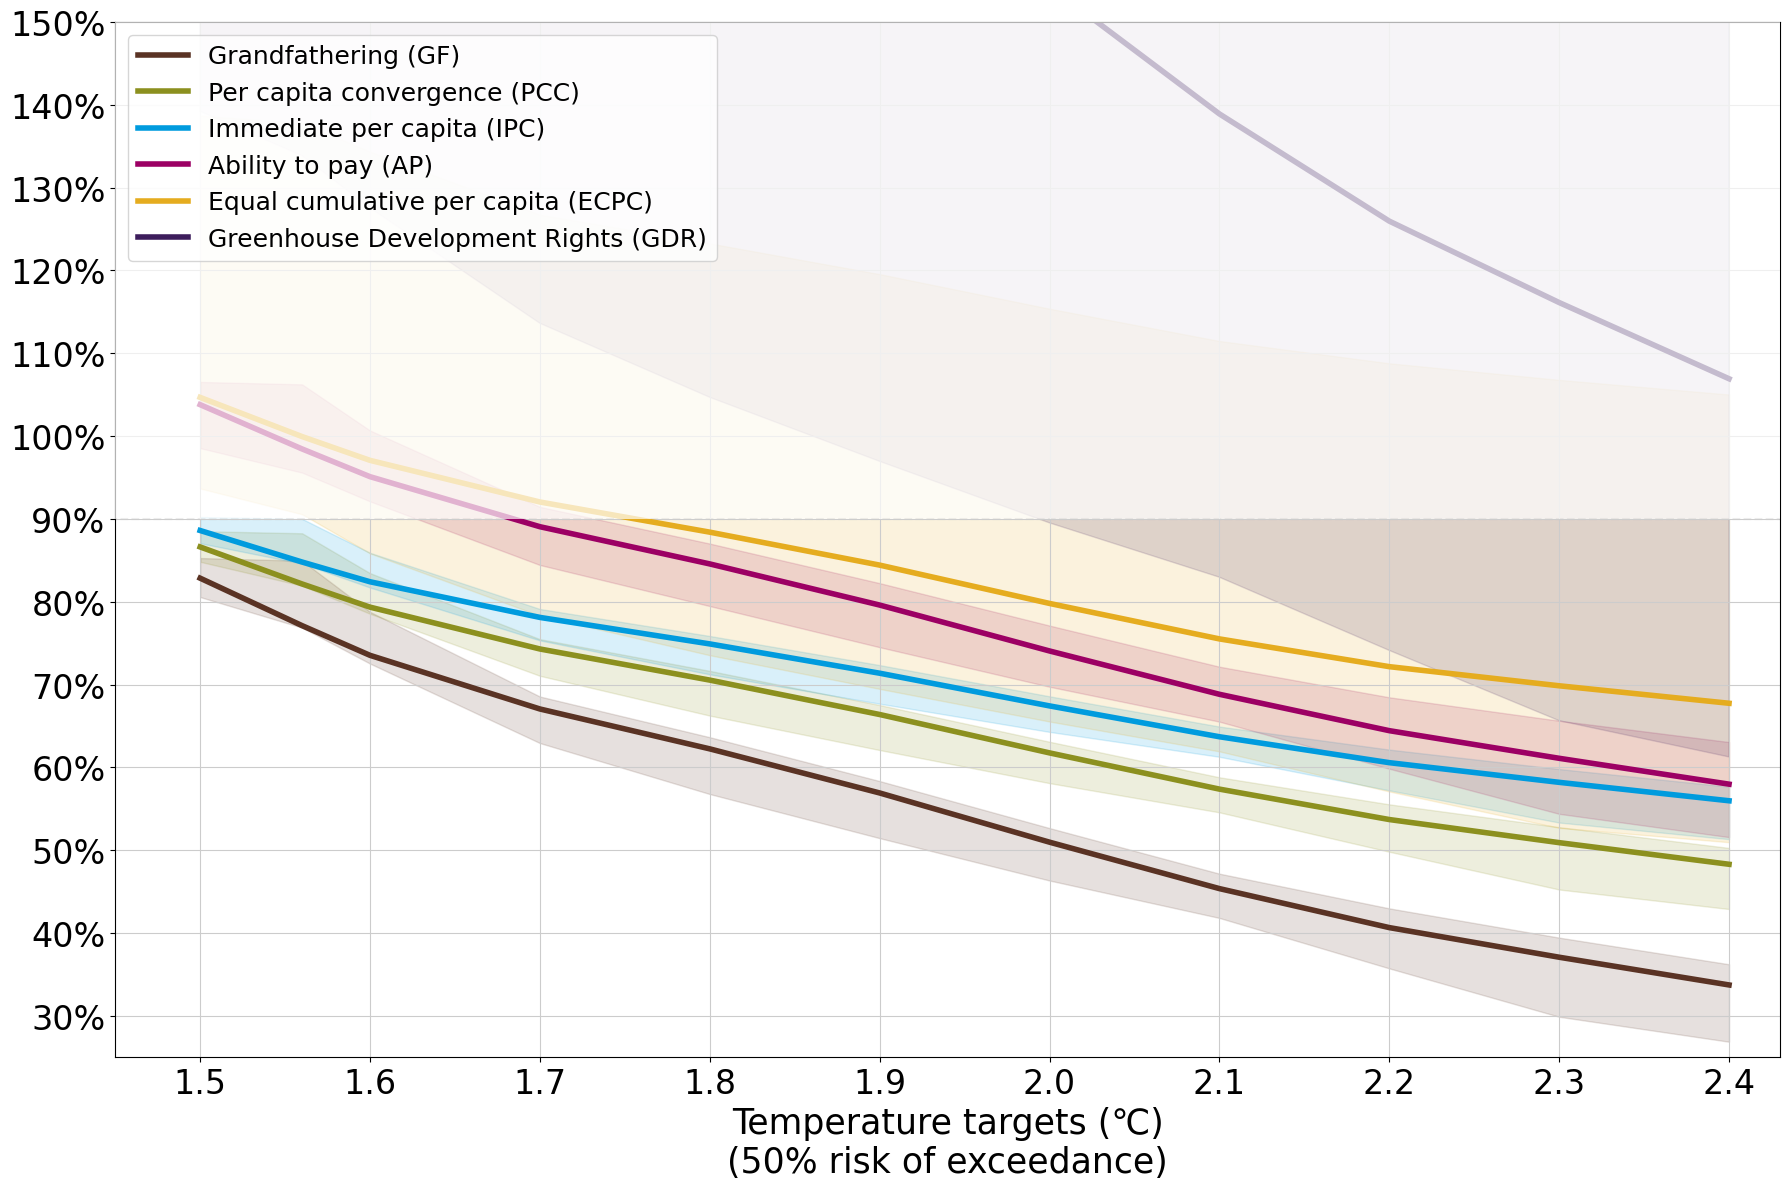

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12), facecolor="w", sharey=True)
year = 2040
ax.set_xlim([1.45, 2.43])
ax.set_xticks(np.arange(1.5, 2.41, 0.1))
# ax.set_xticklabels([str(i.round(1))+"℃" for i in np.arange(1.5, 2.31, 0.1)])

ax.set_ylim([25, 150])
ax.set_yticks(np.arange(30, 151, 10))
ax.set_yticklabels([str(i.round(1)) + "%" for i in np.arange(30, 151, 10)])

# vert(ax, 1.5, 86, 2)
# vert(ax, 1.5, 84, 1)
# vert(ax, 1.5, 79, 0)
# vert(ax, 1.66, 90, 3)
# vert(ax, 2.1, 90, 4)

for rule_i, rule in enumerate(rules):
    dat = (
        xr_nld.sel(Risk=0.5, NegEmis=0.3, NonCO2red=0.5, Timing="Immediate")
        .sel(
            {
                "Scenario": "SSP2",
                "Convergence_year": 2050,
                "Discount_factor": 0,
                "RCI_weight": "Half",
                "Capability_threshold": "Th",
                "Historical_startyear": 1990,
            }
        )[rule]
        .sel(Time=year)
    )
    reds = -(dat - emis_1990) / emis_1990 * 100
    wh = np.where(reds >= 90)[0]
    ax.plot(dat.Temperature, reds, lw=4, c=rulecolors[rule_i], label=rulenames[rule_i])
    y2 = (
        -(
            xr_nld.sel({"Risk": 0.5, "Convergence_year": 2050, "NonCO2red": [0.33, 0.5, 0.67]})
            .sel(Time=year)
            .max(
                dim=[
                    "Timing",
                    "Scenario",
                    "NonCO2red",
                    "NegEmis",
                    "Discount_factor",
                    "RCI_weight",
                    "Capability_threshold",
                    "Historical_startyear",
                ],
                skipna=True,
            )[rule]
            - emis_1990
        )
        / emis_1990
        * 100
    )
    y1 = (
        -(
            xr_nld.sel({"Risk": 0.5, "Convergence_year": 2050, "NonCO2red": [0.33, 0.5, 0.67]})
            .sel(Time=year)
            .min(
                dim=[
                    "Timing",
                    "Scenario",
                    "NonCO2red",
                    "NegEmis",
                    "Discount_factor",
                    "RCI_weight",
                    "Capability_threshold",
                    "Historical_startyear",
                ],
                skipna=True,
            )[rule]
            - emis_1990
        )
        / emis_1990
        * 100
    )
    ax.fill_between(dat.Temperature, y1, y2, where=y1 >= y2, color=rulecolors[rule_i], alpha=0.15)

ax.plot([-1e3, 1e5], [90, 90], "--", c="silver", zorder=-1e9)

ax.xaxis.set_tick_params(labelsize=24)
ax.yaxis.set_tick_params(labelsize=24)
ax.set_xlabel("Temperature targets (℃)\n(50% risk of exceedance)", fontsize=25)
x = np.linspace(-1e3, 2040, 10)
y2 = np.array([90] * len(x))
y1 = np.array([1e3] * len(x))
ax.fill_between(x, y1, y2, where=y1 >= y2, alpha=0.7, zorder=1e9, color="w", edgecolor="w", lw=0)

ax.legend(loc="upper left", fontsize=18).set_zorder(1e9 + 3)

# ax.text(2.41, 92, 'target insufficient\nwhen measured by fairness rule', rotation=90, fontsize=12, va='bottom', ha='left', color='grey', zorder=1e9+3)
# ax.text(2.41, 88, 'target sufficient at\ntemperature target', rotation=90, fontsize=12, va='top', ha='left', color='grey')
# ax.text(2.41, 90, 'European 2040 target (90%)', bbox=dict(boxstyle="round", fc='white', ec=None, lw=0, alpha=0.5), fontsize=15, ha='right', va='center', zorder=1e9+3)

# ax.set_ylabel('Greenhouse gas reductions by 2040\n(% with respect to 1990)', fontsize=25)

# ax.plot([1.55, 1.505], [45, 75], 'grey', zorder=1e999)
# ax.text(1.55, 45, textit("GF, PCC and PC require even fewer")+'\n'+textit("reductions than the European target"), va='center', fontsize=18)

# ax.plot([1.75, 1.67], [105, 92], 'grey', zorder=1e999)
# ax.plot([2.1, 2.11], [91, 99], 'grey', zorder=1e999)
# ax.text(1.75, 105, textit("When placed in light of AP,")+'\n'+textit("the European target is associated")+'\n'+textit("with around 1.7 degrees temperature rise (ECPC around 2.1)"), va='center', fontsize=18, zorder=1e99)

# ax.plot([2.10, 2.15], [135, 136], 'grey', zorder=1e999)
# ax.text(2.15, 136, textit("The European target is not")+'\n'+textit("fair for any of the analyzed")+'\n'+textit("temperature levels,")+'\n'+textit("according to GDR"), va='center', fontsize=18, zorder=1e99)

ax.grid(color="0.8")
fig.tight_layout()
# plt.savefig("K:/Code/EffortSharing/Figures/PBL_report/Fig_temp.png", dpi=250)